# K-Means Clustering applied to Sporulation Dataset

## Introduction

This Jupyter Notebook contains all the code used to replicate the results from the paper [Comparisons and validation of statistical clustering techniques for microarray gene expression data](../docs/papers/A1-Comparison-Bioinformatics-2003-Datta.pdf), in particular, the application of *K-Means clustering* to the *Sporulation Dataset*, which contains data from the output of DNA microarrays, which captured the expression levels of nearly every yeast gene during sporulation, first published in the paper [Transcriptional Program of Sportulation in Budding Yeast](../docs/papers/A2-The%20Transcriptional%20Program%20of%20Sporulation%20in%20Budding%20Yeast.pdf).

In [2]:
# Import libraries
import pandas as pd # DataFrame manipulation

import matplotlib.pyplot as plt # Data visualization
from matplotlib import rcParams # Params for in-line visualization
import seaborn as sns # Further visualization
import scienceplots # Plotting style settings
plt.style.use(['science', 'notebook', 'std-colors', 'grid'])
rcParams['figure.figsize'] = [10, 5]  # Set up image visualization params

## Methodology

This sections illustrates the pre-processing steps, hyperparameter tuning, plot generation, etc. That has been developed in order to obtain our results with the K-Means algorithm applied to the Sporulation Dataset.

In [132]:
# Load the Dataset
data = pd.read_csv('../data/sporulation-filtered.txt', delimiter="\t", header=None)
data.columns = data.iloc[0] # Set the first row as columns
data = data[1:] # Ignore first row
# Take a look at the first rows
data.head()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,"1,163781","-1,758143","-0,31495","0,283874","-0,6779","0,470183","0,833156"
2,YAL036C,"0,955552","-1,48956","-0,499057","-0,099143","-0,674453","1,414381","0,39228"
3,YAL040C,"1,454598","-0,735149","-0,073602","-0,618896","-0,789697","1,391507","-0,62876"
4,YDL037c,"1,698578","-1,268638","-0,375511","0,996817","-0,319158","-0,344837","-0,387251"
5,YDR184C,"1,302831","-1,338633","-0,555163","-0,101402","-0,674167","1,317301","0,049233"


In [38]:
# Take a look at the last rows
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"
475,"Mean 1,358206","-0,888829","-0,353535","-0,467139","-0,787436","0,1887355","0,949998",NaN
476,"stad 0,43970021","0,9559518","0,410392755","0,614475086","0,098266629","0,329643282","0,057125036",NaN


In [133]:

# Ignore last 2 rows, since they contains the mean and standard deviation of the columns
# also, they are incorrectly loaded, leaving NaN values for t11,5
data = data.iloc[:-2, :]
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
470,YPL079W,"1,47357","-0,980588","0,187547","-0,775976","-1,067287","0,126038","1,036696"
471,YPL081W,"1,543327","-1,09","-0,374713","-0,780946","-0,671057","0,308319","1,065071"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"


#### Exploratory Data Analysis

1. **Check for Missing values**

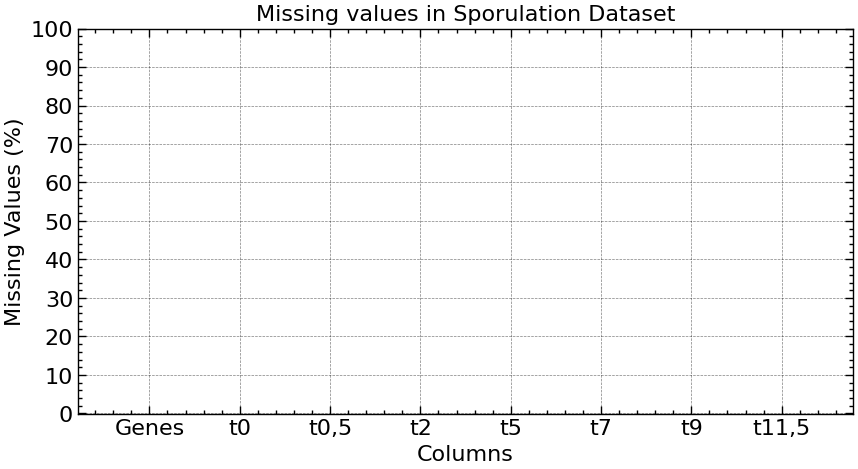

In [53]:
missing = data.isnull().sum() # Compute the sum of True values for each column
missing = missing / data.shape[0]
# Plot the results
plt.bar(x=missing.index, height=missing.values)
plt.title('Missing values in Sporulation Dataset')
plt.ylabel('Missing Values (%)')
plt.yticks(range(0, 110, 10))
plt.xlabel('Columns')
plt.show()

In [151]:
# Now that we know there are not any NA values, convert the string values 
# to float: Replace ',' with '.' and change data type
#data.iloc[:, 1:] = data.iloc[:, 1:].replace(',', '.', regex=True).astype(float)
df = data
df

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,1.163781,-1.758143,-0.31495,0.283874,-0.6779,0.470183,0.833156
2,YAL036C,0.955552,-1.48956,-0.499057,-0.099143,-0.674453,1.414381,0.39228
3,YAL040C,1.454598,-0.735149,-0.073602,-0.618896,-0.789697,1.391507,-0.62876
4,YDL037c,1.698578,-1.268638,-0.375511,0.996817,-0.319158,-0.344837,-0.387251
5,YDR184C,1.302831,-1.338633,-0.555163,-0.101402,-0.674167,1.317301,0.049233
...,...,...,...,...,...,...,...,...
470,YPL079W,1.47357,-0.980588,0.187547,-0.775976,-1.067287,0.126038,1.036696
471,YPL081W,1.543327,-1.09,-0.374713,-0.780946,-0.671057,0.308319,1.065071
472,YPL090C,1.85523,-0.550056,-0.264951,-1.042622,-0.729874,-0.019525,0.751798
473,YPL131W,1.785611,-0.406223,-0.895333,-0.585125,-0.81687,0.003997,0.913943


In [152]:
genes_col = df['Genes']

# Step 2: Drop the 'Genes' column from the DataFrame
df = df.drop(columns=['Genes'])

# Step 3: Replace commas with periods and convert the remaining columns to float
df = df.replace(',', '.', regex=True).astype(float)

# Step 4: Paste the 'Genes' column back into the DataFrame
df['Genes'] = genes_col

# Step 5: Move 'Genes' column to the first position
df = df[['Genes'] + [col for col in df.columns if col != 'Genes']]

df.dtypes

/tmp/ipykernel_10871/727248874.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(',', '.', regex=True).astype(float)


,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,1.163781,-1.758143,-0.314950,0.283874,-0.677900,0.470183,0.833156
2,YAL036C,0.955552,-1.489560,-0.499057,-0.099143,-0.674453,1.414381,0.392280
3,YAL040C,1.454598,-0.735149,-0.073602,-0.618896,-0.789697,1.391507,-0.628760
4,YDL037c,1.698578,-1.268638,-0.375511,0.996817,-0.319158,-0.344837,-0.387251
5,YDR184C,1.302831,-1.338633,-0.555163,-0.101402,-0.674167,1.317301,0.049233
...,...,...,...,...,...,...,...,...
470,YPL079W,1.473570,-0.980588,0.187547,-0.775976,-1.067287,0.126038,1.036696
471,YPL081W,1.543327,-1.090000,-0.374713,-0.780946,-0.671057,0.308319,1.065071
472,YPL090C,1.855230,-0.550056,-0.264951,-1.042622,-0.729874,-0.019525,0.751798
473,YPL131W,1.785611,-0.406223,-0.895333,-0.585125,-0.816870,0.003997,0.913943


2. **Distribution of Gene Expression Levels**

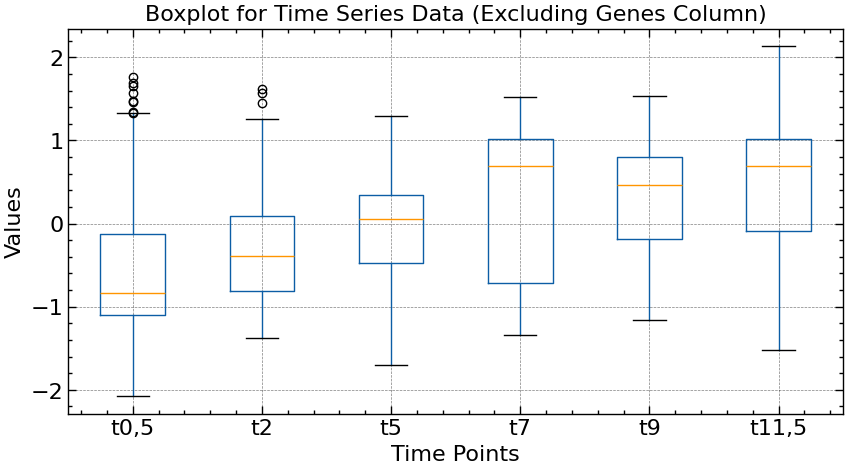

In [82]:
import numpy as np

# Replace commas with dots and convert to float, excluding the 'Genes' column

# Create a boxplot for all numerical columns
data.boxplot()

# Customize the plot
plt.title("Boxplot for Time Series Data (Excluding Genes Column)")
plt.ylabel("Values")
plt.xlabel("Time Points")

# Show the plot
plt.show()